## GridSearch

在機器學習中，本身的資料源和特徵資料處理其實是界定模型的準度上限(upper bound)，不同的演算法只是去逼近這個上限。我們測試不同的演算法同時，我們可以進行不同參數的評估與計算準確率來逼近上限。

以下用 LightGBM 來示範 GridSearch(網格搜索法)，可以輸入自己想要的參數組合，藉此找到最優的參數。

In [1]:
# LightGBM
import warnings
warnings.filterwarnings("ignore")

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Book_Purchased.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 5].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

import lightgbm as lgb
from lightgbm import LGBMClassifier

# 建立參數
param_grid = {
    'num_leaves': [30, 40], 
    'feature_fraction': [0.2, 0.3],
    'bagging_fraction': [0.6, 0.7],
    'max_depth':[3, 5, 7],
    'max_bin':[20],
    'lambda_l1':[0.3, 0.6],
    'lambda_l2':[0.08, 0.09],
    'min_split_gain':[0.04, 0.05],
    'min_child_weight':[7]
}

# 建立LightGBM模型
classifier = lgb.LGBMClassifier(objective = 'binary', 
                                learning_rate = 0.05, 
                                n_estimators = 100, 
                                random_state=0)
# GridSearchCV
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(classifier, param_grid)

# 使用訓練資料訓練模型
gridsearch.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current valu

GridSearchCV(estimator=LGBMClassifier(learning_rate=0.05, objective='binary',
                                      random_state=0),
             param_grid={'bagging_fraction': [0.6, 0.7],
                         'feature_fraction': [0.2, 0.3],
                         'lambda_l1': [0.3, 0.6], 'lambda_l2': [0.08, 0.09],
                         'max_bin': [20], 'max_depth': [3, 5, 7],
                         'min_child_weight': [7],
                         'min_split_gain': [0.04, 0.05],
                         'num_leaves': [30, 40]})

In [2]:
# Final Model
print('Start predicting...')
LGBM = lgb.LGBMClassifier(objective = 'binary',
                         learning_rate = 0.05, 
                         n_estimators = 100, 
                         random_state=0,
                         num_leaves = gridsearch.best_params_['num_leaves'],
                         feature_fraction = gridsearch.best_params_['feature_fraction'], 
                         bagging_fraction = gridsearch.best_params_['bagging_fraction'],
                         max_depth = gridsearch.best_params_['max_depth'],
                         max_bin = gridsearch.best_params_['max_bin'],
                         lambda_l1 = gridsearch.best_params_['lambda_l1'],
                         lambda_l2 = gridsearch.best_params_['lambda_l2'],
                         min_split_gain = gridsearch.best_params_['min_split_gain'],
                         min_child_weight = gridsearch.best_params_['min_child_weight'])
%time LGBM_fit = LGBM.fit(X_train, y_train)
print('Predicting is over')

Start predicting...
CPU times: user 189 ms, sys: 8.93 ms, total: 198 ms
Wall time: 44.5 ms
Predicting is over


In [3]:
# Function for Measure Performance# 
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

Accuracy:0.840
Classification report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        67
           1       0.81      0.67      0.73        33

    accuracy                           0.84       100
   macro avg       0.83      0.80      0.81       100
weighted avg       0.84      0.84      0.84       100

Confusion matrix
[[62  5]
 [11 22]]
ROC AUC Score
0.8511985526910901
Feature importances: [327, 0]
Plot feature importances...


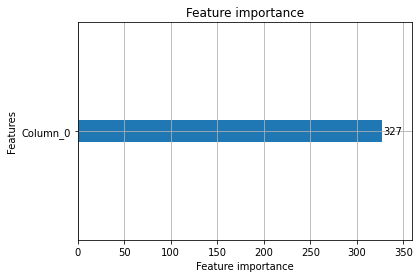

In [4]:
# performance
LGBM_grid_measure = measure_performance(X=X_test, y=y_test, clf=LGBM_fit, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_fit.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_fit, max_num_features=len(dataset))
plt.show()

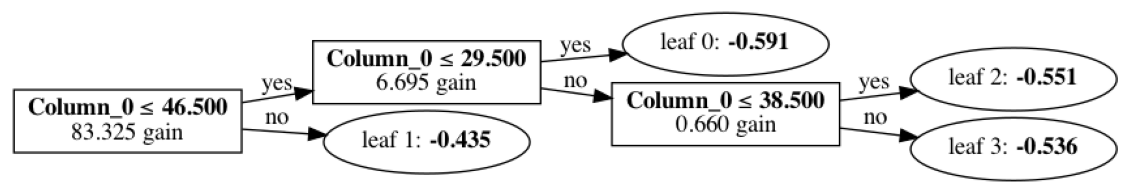

In [5]:
ax = lgb.plot_tree(LGBM_fit, figsize=(20, 8), show_info=['split_gain'])
plt.show()